In [58]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import os
if os.path.basename(os.getcwd()) != 'food-pairing':
    os.chdir(os.path.dirname(os.getcwd()))

from utils.data_loading import read_food_molecules
import matplotlib.pyplot as plt
import plotly.express as px

In [59]:
def pad_lists(lst, max_len: int = 10):
    out = [0] * max_len
    if len(lst) == max_len:
        lst = [*map(int, lst)]
        return np.asarray(lst)
    elif len(lst) < max_len:
        out[:len(lst)] = lst
        out = [*map(int, out)]
        return np.asarray(out)
    else:
        lst = [*map(int, lst)]
        return np.asarray(lst[:max_len])

In [92]:
def find_n_neighbours(df, model, target_id, n_neighbors=10):
    target_id_vec = df.loc[df['id'] == target_id, 'molecules']
    if len(target_id_vec) == 0: 
        return [0], [0]
    target_id_vec = target_id_vec.values.tolist()
    distances, indices = model.kneighbors(
        target_id_vec,
        n_neighbors=n_neighbors+1)
    indices = indices.squeeze().tolist()
    for index in indices:
        index = (df.iloc[index])['id']
        # indices[i] = (df.index.to_list())[indices[i]]
    raw_recommends = \
        sorted(
            list(
                zip(
                    indices,
                    distances.squeeze().tolist()
                )
            ),
            key=lambda x: x[1]
        )[:0:-1]

    sorted_indices = [x[0] for x in raw_recommends]

    return raw_recommends, sorted_indices


In [61]:
flavor_df = read_food_molecules()

flavor_df['molecules'] = flavor_df['molecules'].apply(lambda x: pad_lists(x))

In [62]:
knn = NearestNeighbors(metric='manhattan', n_neighbors=10, n_jobs=-1)

y = flavor_df['molecules'].values
x = flavor_df['id'].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

knn.fit(y.tolist())

NearestNeighbors(metric='manhattan', n_jobs=-1, n_neighbors=10)

In [94]:
entity = 'apple'
entity_id = flavor_df.loc[flavor_df['ingredient'] == entity, 'id']

raw_recommends, sorted_indices = find_n_neighbours(flavor_df, knn, int(entity_id.iloc[0]))

In [95]:
reccomends = [str((flavor_df.loc[flavor_df['id'] == x, 'ingredient']).iloc[0]) for x in sorted_indices]

In [96]:
reccomends

['peanut oil',
 'winter savory',
 'radish',
 'rambutan',
 'ricotta cheese',
 'wild cherry',
 'scotch spearmint',
 'redskin onion',
 'mustard',
 'orange']

In [16]:
y = np.stack(y.tolist(), axis=0)

In [17]:
from sklearn.manifold import TSNE

n_iter = 500
perplexity = 30
metric = "euclidean"
# TSNE requires a certain number of neighbors which depends on the
# perplexity parameter.
# Add one since we include each sample as its own neighbor.
n_neighbors = int(3.0 * perplexity + 1) + 1

tsne_params = dict(
    init="random",  # pca not supported for sparse matrices
    perplexity=perplexity,
    method="barnes_hut",
    random_state=42,
    n_iter=n_iter,
    learning_rate="auto",
)

flavor_emb = TSNE(metric="euclidean", **tsne_params).fit_transform(y)

In [18]:
print((flavor_emb).shape)

(812, 2)


In [20]:
fig = px.scatter(
    flavor_emb, x=0, y=1,
    text=flavor_df['ingredient']
)
fig.update_traces(textposition='top center')

fig.update_layout(  
    height=800,
    title_text='Flavor t-SNE'
)
fig.show()

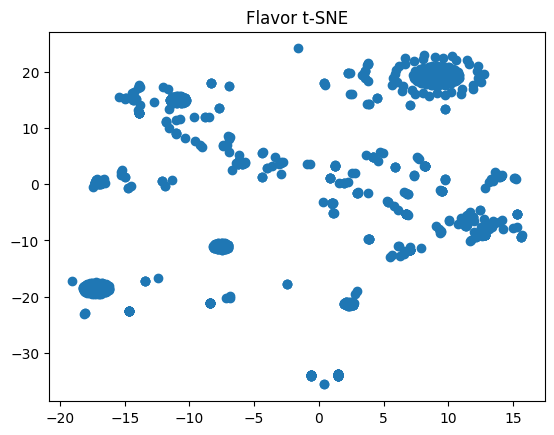

In [21]:
fig, ax = plt.subplots()

ax.set_title("Flavor t-SNE")
ax.scatter(
    flavor_emb[:, 0],
    flavor_emb[:, 1],
    #c=y.astype(np.int32),
    #alpha=0.2,
    #cmap=plt.cm.viridis,
)
plt.show()

## FooDB test
___

In [27]:
foodb_df = read_food_molecules('foodb')

foodb_df['molecules'] = foodb_df['molecules'].apply(lambda x: pad_lists(x))

In [28]:
knn = NearestNeighbors(metric='manhattan', n_neighbors=10, n_jobs=-1)

y = foodb_df['molecules'].values
x = foodb_df['id'].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

knn.fit(y.tolist())

NearestNeighbors(metric='manhattan', n_jobs=-1, n_neighbors=10)

In [56]:
def find_n_neighbours(df, model, target_id, n_neighbors=10):
    target_id_vec = df.loc[df['id'] == target_id, 'molecules']
    print(target_id_vec)
    if len(target_id_vec) == 0: return [0], [0]
    target_id_vec = target_id_vec.values.tolist()
    distances, indices = model.kneighbors(
        target_id_vec,
        n_neighbors=n_neighbors+1)
    print(indices)
    indices = indices.squeeze().tolist()

    for i in (range(len(indices))):
        indices[i] = df['id'].loc[df['molecules']==indices[i]]
       # indices[i] = (df.index.to_list())[indices[i]]

    raw_recommends = \
        sorted(
            list(
                zip(
                    indices,
                    distances.squeeze().tolist()
                )
            ),
            key=lambda x: x[1]
        )[:0:-1]

    sorted_indices = [x[0] for x in raw_recommends]

    return raw_recommends, sorted_indices


In [52]:
entity_id

29

In [57]:
entity = 'Kiwi'
entity_id = foodb_df.loc[foodb_df['ingredient'] == entity, 'id'].iloc[0]

_, sorted_indices = find_n_neighbours(foodb_df, knn, entity_id)

# reccomends = [str((foodb_df.loc[foodb_df['id'] == x, 'ingredient']).iloc[0]) for x in sorted_indices]

35        [3, 3, 2, 5, 13393, 39, 3513, 3716, 1131, 13401]
36                          [3, 2, 1, 0, 0, 0, 0, 0, 0, 0]
37                       [2576, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11849    [13393, 3513, 21462, 3522, 1111, 1224, 3521, 3...
11850    [17709, 17707, 18839, 17121, 2582, 17712, 1220...
Name: molecules, dtype: object
[[632 658 510 531 506 629 505 683  94 131 300]
 [632 658 629 531 506 510 505 683  94 131 300]
 [ 94 632 658 531 505 510 683 506 629 131 300]
 [315 141 272  86 301 108 300 131  99  94 683]
 [400 196 219   9 294 226  99 211   0 272 141]]


ValueError: ('Lengths must match to compare', (12386,), (11,))

In [ ]:
sorted_indices

[0]

In [31]:
foodb_df.index.to_list()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
